# Plotting our Results

In [52]:
# Importing relevant libraries
import matplotlib.pyplot as plt
from data_utils import pull_stock_data, pull_stock_indicators, cleaning_data
import json 
import pandas as pd
import torch
import pandas as pd
from lstm_datasets import ValTimeSeriesDataset
from lstm import LSTM
from matplotlib.animation import FuncAnimation

### Plotting losses

In [2]:
# File paths
runs_to_plot = ['run_stats/run_stats_hourly_day.json','run_stats/run_stats_day_week.json','run_stats/run_stats_day_month.json','run_stats/run_stats_week_year.json']
lstm_epochs = 30

In [3]:
# Loading the saved dict with all loses
data_to_plot = []
for run_to_plot in runs_to_plot:
    with open(run_to_plot, 'r') as f:
        loss_dict = json.load(f)
        data_to_plot.append(loss_dict)

In [11]:
def plot_tickers(tickers, loss_dict):
    """
    Superimposes the training and validation loss plots for a given list of stock tickers.
    
    Parameters:
    tickers (list): A list of stock ticker symbols (strings) for which the loss data will be plotted.
    loss_dict (dict): A dictionary containing loss data with the following structure:
                      {
                          'train_loss': {
                              'TICKER1': [list of training losses per epoch],
                              'TICKER2': [list of training losses per epoch],
                              ...
                          },
                          'val_loss': {
                              'TICKER1': [list of validation losses per epoch],
                              'TICKER2': [list of validation losses per epoch],
                              ...
                          }
                      }
    Returns:
    None
    """
    
    # Creating figure with two subplots for Train Loss and Val Loss
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
    
    # Setting titles for the subplots
    ax1.title.set_text('Train Loss')
    ax2.title.set_text('Val Loss')
    
    # Creating a secondary y-axis for accuracy on the second subplot
    ax3 = ax2.twinx()
    
    # Setting labels and colors for the secondary y-axis
    color = 'tab:blue'
    ax3.set_ylabel('Accuracy', color=color)
    ax3.tick_params(axis='y', labelcolor=color)
    
    # Setting labels and colors for the primary y-axis
    color = 'tab:green'
    ax2.set_ylabel('Loss', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_ylabel('Loss', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Setting x-axis labels for both subplots
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    
    # Plotting the training and validation loss for each ticker
    for ticker in tickers:
        x = [epoch + 1 for epoch in range(len(loss_dict['train_loss'][ticker]))]
        lstm_train_loss = loss_dict['train_loss'][ticker]
        lstm_val_loss = loss_dict['val_loss'][ticker]
        
        ax1.plot(x, lstm_train_loss, label=f'{ticker} Train Loss')
        ax2.plot(x, lstm_val_loss, label=f'{ticker} Val Loss')
    
    # Showing the plot
    plt.show()

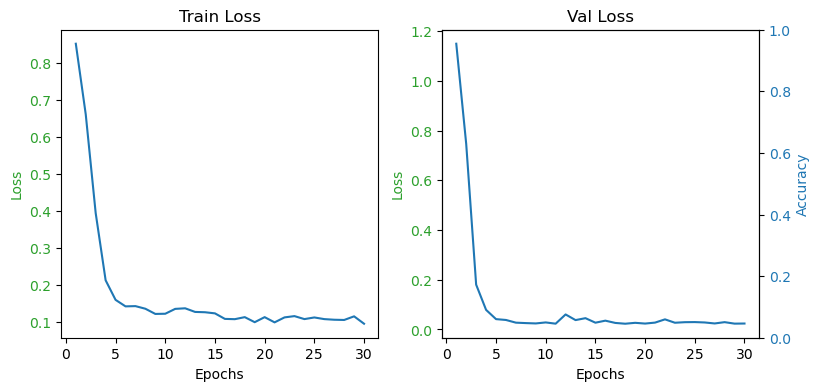

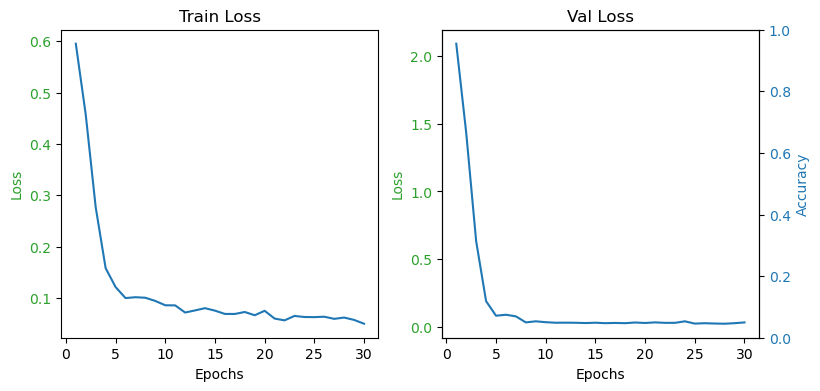

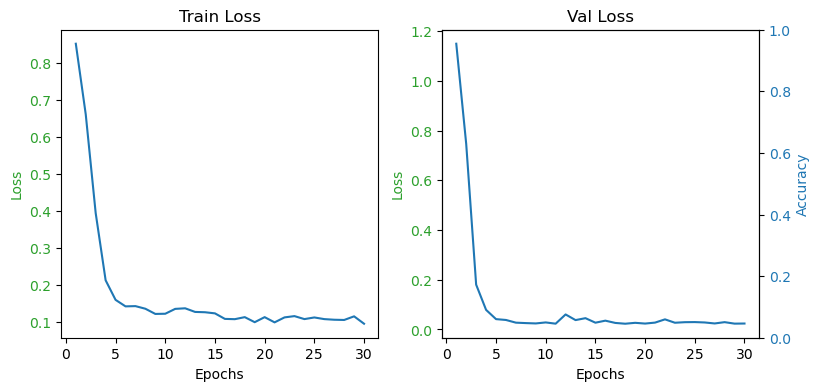

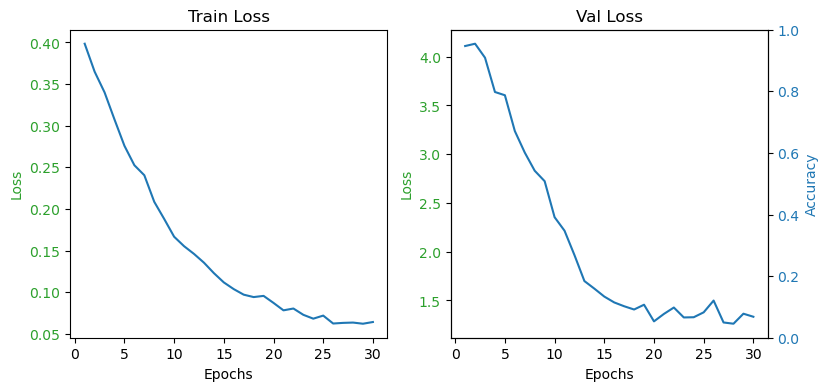

In [12]:
# For a certain ticker, print its loss curves
ticker = "AAPL"
for dp in data_to_plot:
    plot_tickers([ticker], dp)

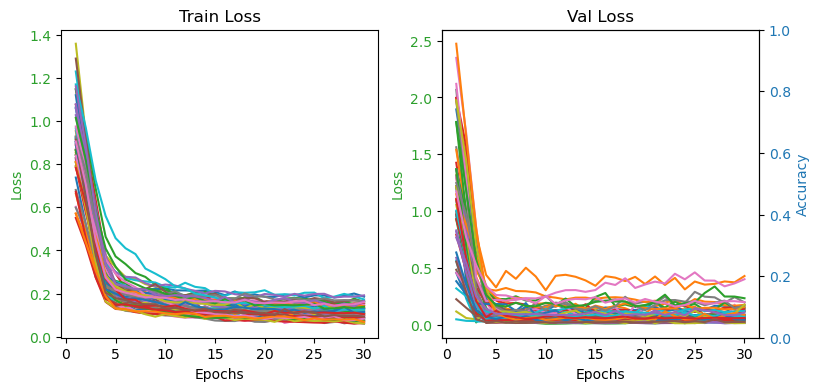

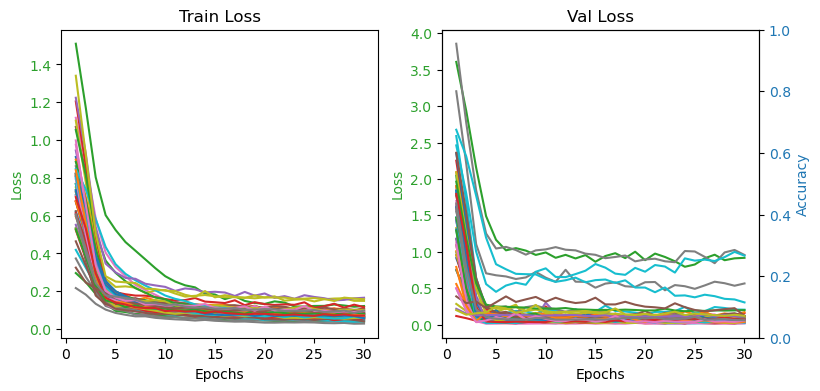

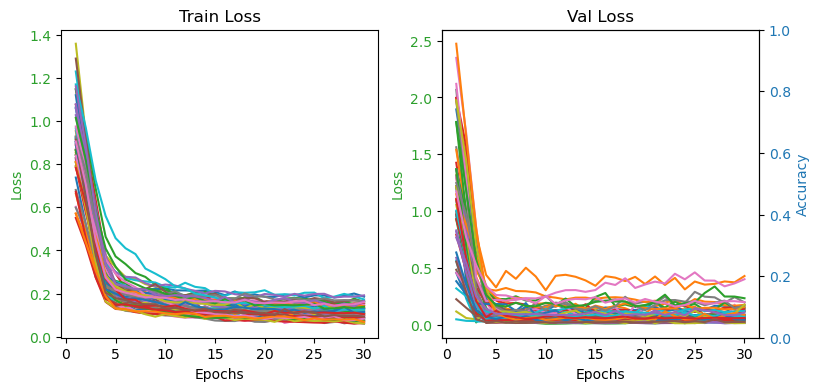

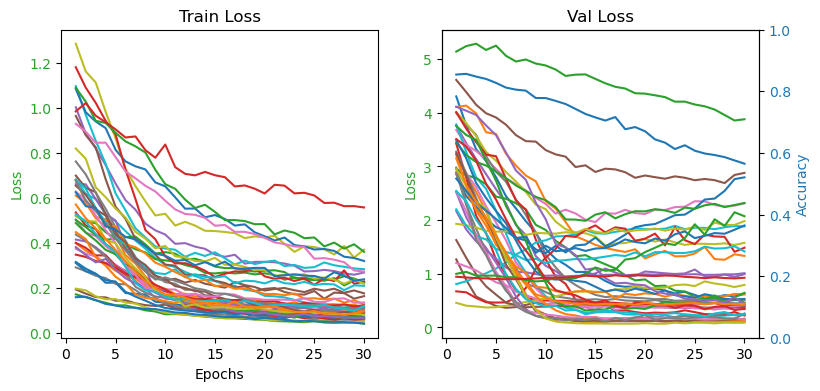

In [13]:
# Print the loss curve of all tickers
for dp in data_to_plot:
    tickers = dp['val_loss'].keys()
    plot_tickers(tickers, dp)

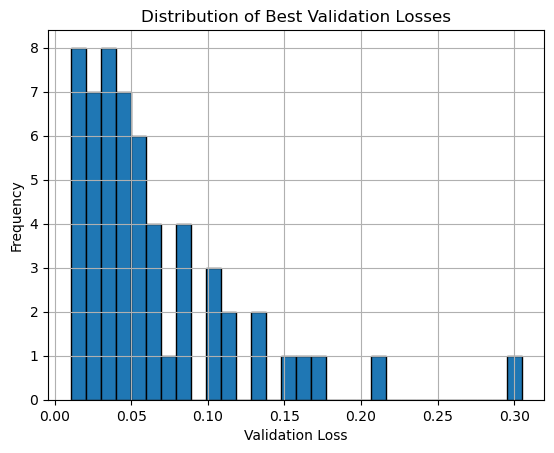

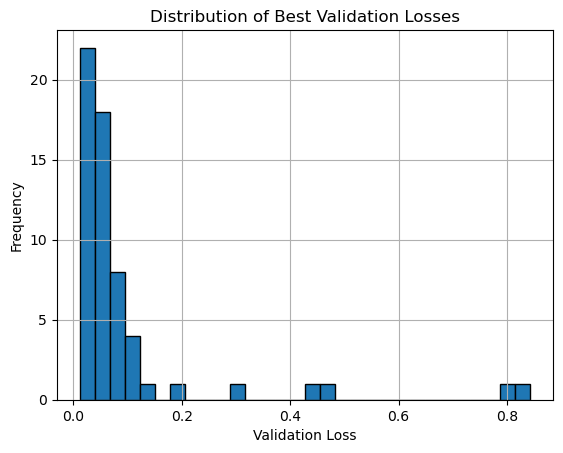

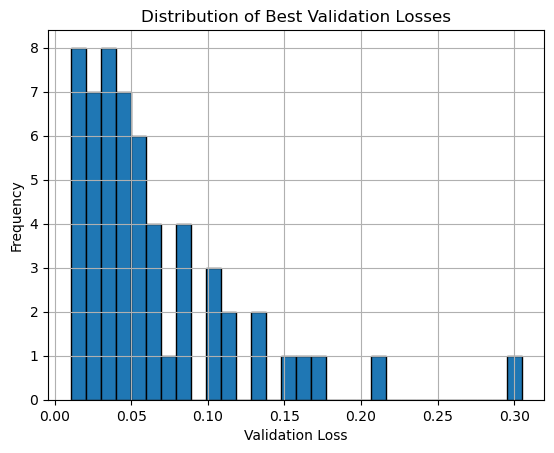

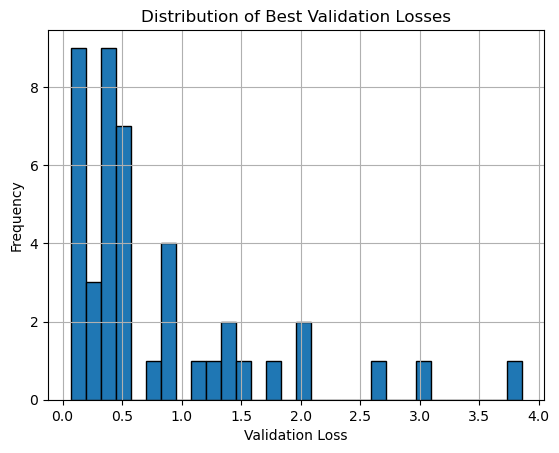

In [15]:
def plot_validation_loss_histogram(data_to_plot):
    """
    Plot a histogram of the best validation losses from a list of dictionaries.
    Parameters:
    data_to_plot (list): A list of dictionaries where each dictionary contains
                         information about the best validation loss for a dataset.
                         Each dictionary should have a 'best_val' key containing
                         a dictionary of {model_name: best_validation_loss} pairs.
    Returns:
    None
    """

    # Iterate over each dictionary in the list
    for dp in data_to_plot:
        
        # Extracting the best validation losses
        data = list(dp['best_val'].values())
        
        # Plot the histogram
        plt.hist(data, bins=30, edgecolor='black')
        
        # Adding title and axis labels
        plt.title('Distribution of Best Validation Losses')
        plt.xlabel('Validation Loss')
        plt.ylabel('Frequency')
        
        # Adding grid for better readability
        plt.grid(True)
        
        # Show the histogram for the current dataset
        plt.show()
        
plot_validation_loss_histogram(data_to_plot)

## Plotting predictions

##### Pull the data

In [5]:
# Obtaining most important company's stocks
tech = ['MSFT','AAPL','NVDA', 'GOOGL', 'GOOG', 'AMZN', 'META', 'AVGO', 'TSLA','ORCL','CRM','NFLX','AMD','QCOM','ADBE','ASML','ADI','DELL']
pharma = ['LLY',"JNJ",'MRK','ABBV','TMO','MRK','MRNA','PFE',"CVS"]
finance = ['BRK-B','JPM','V','MA','BAC','WFC', 'ACN', 'MS','BLK','GS',"PYPL"]
defense = ['BA','LMT','RTX','GE','NOC']
energy = ['XOM','CVX','LIN','SBGSY']
retail = ['WMT', "UNH", "PG", 'COST', 'HD','KO','PEP','MCD','LVMUY', 'NSRGY','TM', 'LRLCY', 'GM', 'BAB','NKE',"T",'F']

all_stocks = tech+pharma+finance+defense+energy+retail

In [39]:
# Pulling historical stock data
start_date = '2023-01-01'
end_date = '2024-01-01'
interval = '1h'

full_stock_data = pull_stock_data(all_stocks, start_date, end_date, interval)
full_stock_data = pull_stock_indicators(full_stock_data)
full_stock_data = cleaning_data(full_stock_data)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

##### Make predictions

In [50]:
def predict_stock_prices(ticker, model_path, data_timeinterval, data, n_lags, forecast_horizon, start_date=None, end_date=None):
    """
    Predicts stock prices over a given interval using an LSTM model.

    Parameters:
    ticker (str): The stock ticker symbol.
    model_path (str): The file path to the trained LSTM model.
    data_timeinterval (str): The time interval of the input data ('hourly', 'daily', etc.).
    data (pd.DataFrame): DataFrame containing historical stock data with columns 'Date' and 'Close'.
    n_lags (int): Number of lagged time steps to consider in the input sequence for prediction.
    forecast_horizon (int): Number of time steps to forecast into the future.
    start_date (str, optional): Start date for prediction in 'YYYY-MM-DD' format. Default is None.
    end_date (str, optional): End date for prediction in 'YYYY-MM-DD' format. Default is None.

    Returns:
    pd.DataFrame: DataFrame containing actual and predicted stock prices with columns 'Close' and 'Predicted_Close'.
    """
    # Load the trained LSTM model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_layers, input_size, hidden_size = 4, 17, 100  # Hyperparameters
    model = LSTM(num_layers, input_size, hidden_size, device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Filter data based on prediction interval
    if start_date and end_date:
        data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

    means = pd.read_csv(f'data_means_stds/train_{data_timeinterval}_mean.csv', index_col=0)
    std_devs = pd.read_csv(f'data_means_stds/train_{data_timeinterval}_std_dev.csv', index_col=0)

    data = (data-means[ticker])/std_devs[ticker]

    # Prepare dataset for prediction
    dataset = ValTimeSeriesDataset(ticker, data, n_lags, forecast_horizon)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=False)


    mean, std_dev = means[ticker]['Close'], std_devs[ticker]['Close']

    # Predict stock prices
    predictions = []
    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)
            output = model(X)*std_dev+mean
            predictions += output.squeeze().tolist()

    # Add predicted prices to DataFrame
    data = data.tail(len(predictions)).copy()*std_dev + mean
    data['Predicted Close'] = predictions
    return data[['Close', 'Predicted Close']]

stock = 'GOOGL'
data = full_stock_data[stock]
n_lags, forecast_horizon = 8 * 30 * 1, 8 * 1
model_path = "LSTMs/"+"LSTM_weights_hourly_day"+"/LSTM_weights/"+stock+".pt"
data_timeinterval = "hourly"

preds = predict_stock_prices(stock, model_path, data_timeinterval, data, n_lags, forecast_horizon)

##### Plot the predictions vs. real data

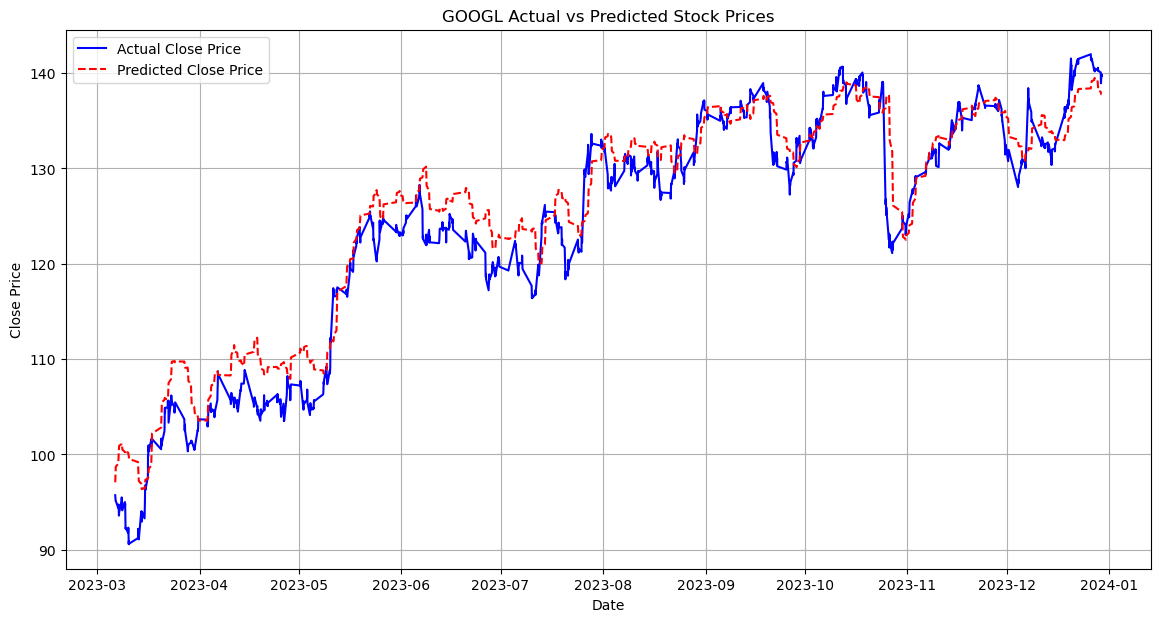

In [56]:
def plot_stock_prediction(data, ticker, start_date=None, end_date=None):
    """
    Plots the actual and predicted stock prices.

    Parameters:
    actual_data (pd.DataFrame): DataFrame containing the actual stock prices with 'Date' and 'Close' columns.
    predicted_data (pd.DataFrame): DataFrame containing the predicted stock prices with 'Date' and 'Predicted_Close' columns.
    ticker (str): The stock ticker symbol.
    start_date (str): Start date for the plot in 'YYYY-MM-DD' format.
    end_date (str): End date for the plot in 'YYYY-MM-DD' format.
    """
    # Filter data based on the date range
    if start_date and end_date:
        data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

    # Plot actual vs predicted
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['Close'], label='Actual Close Price', color='blue')
    plt.plot(data.index, data['Predicted Close'], label='Predicted Close Price', color='red', linestyle='--')

    # Adding titles and labels
    plt.title(f'{ticker} Actual vs Predicted Stock Prices')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_stock_prediction(preds, stock, start_date=None, end_date=None)